### Define dataset

In [33]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
from PIL import Image, ImageDraw
import random
import matplotlib.pyplot as plt


class ShapesDataset(Dataset):
    def __init__(self, num_images, resolution=64, radius=8, transform=None):
        """
        Initializes the dataset.

        Parameters:
        - num_images: Integer specifying the number of images in the dataset.
        - transform: Optional torchvision transforms to apply to the images.
        """
        self.num_images = num_images
        self.shapes = ['triangle', 'circle', 'square']
        self.canvas_size = resolution
        self.transform = transform
        self.shape_to_idx = {'triangle': 0, 'circle': 1, 'square': 2}
        self.idx_to_shape = {0: 'triangle', 1: 'circle', 2: 'square'}
        self.radius = radius
        self.canvas_size = resolution
        
        # Define overlap tolerance (as percentage of shape area)
        self.overlap_tolerance = 0.05  # 5% overlap threshold
        
        # Define bounding box margins for different shapes
        self.shape_bounds = {
            'circle': lambda r: (2*r, 2*r),
            'square': lambda r: (2*r, 2*r),
            'triangle': lambda r: (2*r, int(2*r * (3**0.5) / 2))
        }
        # Updated spatial relationship phrases including occlusion
        self.spatial_phrases = {
            'upper_left': ['to the upper left of', 'above and to the left of', 'diagonally up and left from'],
            'upper_right': ['to the upper right of', 'above and to the right of', 'diagonally up and right from'],
            'lower_left': ['to the lower left of', 'below and to the left of', 'diagonally down and left from'],
            'lower_right': ['to the lower right of', 'below and to the right of', 'diagonally down and right from'],
            'above': ['above', 'directly above', 'higher than'],
            'below': ['below', 'directly below', 'lower than'],
            'left': ['to the left of', 'left of'],
            'right': ['to the right of', 'right of'],
            'in_front': ['in front of', 'overlapping and in front of'],
            'behind': ['behind', 'overlapped by']
        }
        #self.draw_sequence = []

    def get_shape_bounds(self, shape, location):
        """
        Get the bounding box for a shape at a given location.
        Returns (left, top, right, bottom)
        """
        x, y = location
        width, height = self.shape_bounds[shape](self.radius)
        
        if shape == 'triangle':
            # Triangle's bounding box is centered horizontally, but offset vertically
            # due to its center of mass being lower
            return (
                x - width//2,          # left
                y - height//3,         # top (offset to match draw_shape_on_image)
                x + width//2,          # right
                y + height*2//3        # bottom
            )
        else:
            # Circle and square are centered on their position
            return (
                x - width//2,    # left
                y - height//2,   # top
                x + width//2,    # right
                y + height//2    # bottom
            )

    def calculate_overlap_area(self, box1, box2):
        """
        Calculate the area of overlap between two bounding boxes.
        """
        # Calculate intersection rectangle
        x_left = max(box1[0], box2[0])
        y_top = max(box1[1], box2[1])
        x_right = min(box1[2], box2[2])
        y_bottom = min(box1[3], box2[3])

        if x_right < x_left or y_bottom < y_top:
            return 0.0

        intersection_area = (x_right - x_left) * (y_bottom - y_top)
        return intersection_area

    def get_shape_area(self, shape):
        """
        Get the approximate area of a shape's bounding box
        """
        width, height = self.shape_bounds[shape](self.radius)
        return width * height

    def check_occlusion(self, shape1, loc1, shape2, loc2):
        """
        Checks if two shapes overlap significantly based on their bounding boxes.
        Now includes tolerance for minimal overlaps.
        """
        box1 = self.get_shape_bounds(shape1, loc1)
        box2 = self.get_shape_bounds(shape2, loc2)
        
        # Calculate overlap area
        overlap_area = self.calculate_overlap_area(box1, box2)
        
        if overlap_area == 0:
            return False
            
        # Calculate the minimum area of both shapes
        area1 = self.get_shape_area(shape1)
        area2 = self.get_shape_area(shape2)
        min_area = min(area1, area2)
        
        # Calculate overlap ratio relative to the smaller shape
        overlap_ratio = overlap_area / min_area
        
        # Return True only if overlap ratio exceeds tolerance
        return overlap_ratio > self.overlap_tolerance
    
    def determine_occlusion_order(self, shapes_order, locations_order):
        """
        Determines which shape is visually in front based on overlap and drawing order.
        Returns True if shape1 is in front, False if shape2 is in front.
        """
        shape1, shape2 = shapes_order
        loc1, loc2 = locations_order
        
        # If shapes are overlapping, last drawn shape is on top
        if self.check_occlusion(shape1, loc1, shape2, loc2):
            return True  # shape1 is on top since it was drawn last in the current order
        
        return None  # No occlusion detected

    def generate_caption(self, shape1_idx, shape2_idx, loc1, loc2, color1=None, color2=None, is_shape1_on_top=None):
        """
        Generates a natural language caption describing the spatial relationship between two shapes.
        Corrected logic for front/behind relationships.
        """
        shape1_name = self.idx_to_shape[shape1_idx]
        shape2_name = self.idx_to_shape[shape2_idx]
        
        # Check for significant occlusion
        is_occluding = self.check_occlusion(shape1_name, loc1, shape2_name, loc2)
        
        if is_occluding:
            # Corrected logic: if shape1 is drawn last (is_shape1_on_top is True),
            # it means it's in front, not behind
            if is_shape1_on_top:
                relation = random.choice(self.spatial_phrases['in_front'])  # shape1 is drawn last, so it's in front
            else:
                relation = random.choice(self.spatial_phrases['behind'])  # shape1 is drawn first, so it's behind
        else:
            # ... [rest of the spatial relationship logic remains the same] ...
            x1, y1 = loc1
            x2, y2 = loc2
            dx = x1 - x2
            dy = y1 - y2
            threshold = 5

            if abs(dx) <= threshold:
                if dy < 0:
                    relation = random.choice(self.spatial_phrases['above'])
                else:
                    relation = random.choice(self.spatial_phrases['below'])
            elif abs(dy) <= threshold:
                if dx < 0:
                    relation = random.choice(self.spatial_phrases['left'])
                else:
                    relation = random.choice(self.spatial_phrases['right'])
            else:
                if dx < 0 and dy < 0:
                    relation = random.choice(self.spatial_phrases['upper_left'])
                elif dx < 0 and dy > 0:
                    relation = random.choice(self.spatial_phrases['lower_left'])
                elif dx > 0 and dy < 0:
                    relation = random.choice(self.spatial_phrases['upper_right'])
                else:
                    relation = random.choice(self.spatial_phrases['lower_right'])

        if color1 is not None and color2 is not None:
            shape1_qualifier = random.choice([color1, ""])
            shape2_qualifier = random.choice([color2, ""])
            caption = f"{shape1_qualifier} {shape1_name} is {relation} {shape2_qualifier} {shape2_name}"
        else:
            caption = f"{shape1_name} is {relation} {shape2_name}"
        
        return caption

    def __len__(self):
        return self.num_images

    def draw_shape_on_image(self, img, shape, location, color='black'):
        """
        Modified to return both the image and a record of what was drawn
        """
        draw = ImageDraw.Draw(img)
        x, y = location

        if shape == 'circle':
            r = self.radius
            leftUpPoint = (x - r, y - r)
            rightDownPoint = (x + r, y + r)
            draw.ellipse([leftUpPoint, rightDownPoint], fill=color)

        elif shape == 'square':
            s = self.radius * 2
            leftUpPoint = (x - s // 2, y - s // 2)
            rightDownPoint = (x + s // 2, y + s // 2)
            draw.rectangle([leftUpPoint, rightDownPoint], fill=color)

        elif shape == 'triangle':
            s = self.radius * 2
            h = s * (3 ** 0.5) / 2
            point1 = (x, y - h / 3)
            point2 = (x - s / 2, y + h * 2 / 3)
            point3 = (x + s / 2, y + h * 2 / 3)
            draw.polygon([point1, point2, point3], fill=color)

        else:
            raise ValueError("Shape must be 'triangle', 'circle', or 'square'.")

        # Return both the image and the shape info
        return img

    def __getitem__(self, idx):
        """
        Modified to include additional labels: colors and spatial relationship
        """
        # Create a blank image
        img = Image.new('RGB', (self.canvas_size, self.canvas_size), 'gray')

        # Randomly select two shapes, make sure they are different
        shape1 = random.choice(self.shapes)
        while True:
            shape2 = random.choice(self.shapes)
            if shape1 != shape2:
                break

        # Randomly select locations
        x1 = random.randint(self.radius + 1, self.canvas_size - self.radius - 1)
        y1 = random.randint(self.radius + 1, self.canvas_size - self.radius - 1)
        x2 = random.randint(self.radius + 1, self.canvas_size - self.radius - 1)
        y2 = random.randint(self.radius + 1, self.canvas_size - self.radius - 1)

        # Always keep shape1 and shape2 references consistent
        shape1_idx = self.shape_to_idx[shape1]
        shape2_idx = self.shape_to_idx[shape2]
        location1 = torch.tensor((x1, y1), dtype=torch.float32)
        location2 = torch.tensor((x2, y2), dtype=torch.float32)

        # Fixed colors for consistency
        color1 = "red"
        color2 = "blue"

        # Randomly decide drawing order but don't swap the shape references
        if random.random() < 0.5:
            # Draw shape2 first, then shape1
            img = self.draw_shape_on_image(img, shape2, (x2, y2), color=color2)
            img = self.draw_shape_on_image(img, shape1, (x1, y1), color=color1)
            is_shape1_on_top = True  # shape1 was drawn last
        else:
            # Draw shape1 first, then shape2
            img = self.draw_shape_on_image(img, shape1, (x1, y1), color=color1)
            img = self.draw_shape_on_image(img, shape2, (x2, y2), color=color2)
            is_shape1_on_top = False  # shape2 was drawn last

        # Determine spatial relationship
        relationship = None
        is_occluding = self.check_occlusion(shape1, (x1, y1), shape2, (x2, y2))
        
        if is_occluding:
            relationship = 'in_front' if is_shape1_on_top else 'behind'
        else:
            dx = x1 - x2
            dy = y1 - y2
            threshold = 5

            if abs(dx) <= threshold:
                relationship = 'above' if dy < 0 else 'below'
            elif abs(dy) <= threshold:
                relationship = 'left' if dx < 0 else 'right'
            else:
                if dx < 0 and dy < 0:
                    relationship = 'upper_left'
                elif dx < 0 and dy > 0:
                    relationship = 'lower_left'
                elif dx > 0 and dy < 0:
                    relationship = 'upper_right'
                else:
                    relationship = 'lower_right'

        # Apply transforms if any
        if self.transform:
            img = self.transform(img)
        else:
            img = transforms.ToTensor()(img)

        # Generate caption using the consistent shape references
        caption = self.generate_caption(
            shape1_idx, shape2_idx,
            (x1, y1), (x2, y2),
            color1, color2,
            is_shape1_on_top
        )

        labels = {
            'shape1': shape1_idx,
            'shape2': shape2_idx,
            'location1': location1,
            'location2': location2,
            'color1': color1,
            'color2': color2,
            'spatial_relationship': relationship,  # This is how shape1 is located relative to shape2
            'caption': caption
        }
        return img, labels

Testing random spatial relationships:
{'shape1': 0, 'shape2': 2, 'location1': tensor([21., 17.]), 'location2': tensor([14., 10.]), 'color1': 'red', 'color2': 'blue', 'spatial_relationship': 'in_front', 'caption': ' triangle is overlapping and in front of  square'}


<Figure size 2000x1500 with 0 Axes>


Relationships found:
in_front: ✗
behind: ✗
left: ✗
right: ✗
above: ✗
below: ✗
upper_left: ✗
upper_right: ✗
lower_left: ✗
lower_right: ✗

Testing specific overlap cases:


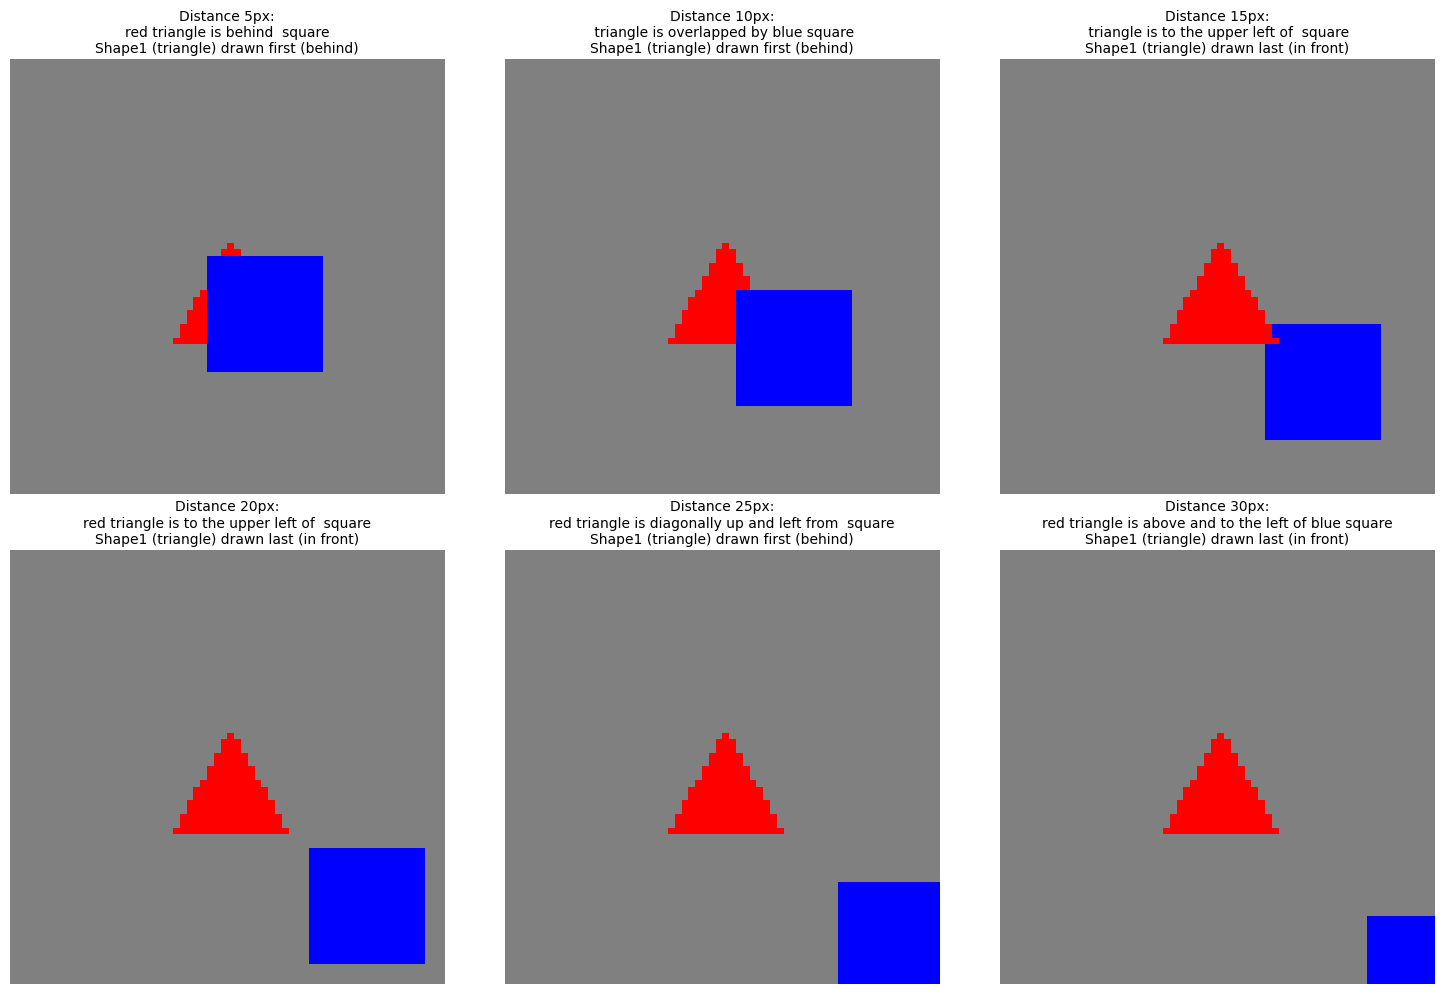

In [34]:
def test_spatial_relationships():
    """
    Test general spatial relationships by generating random samples
    """
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    dataset = ShapesDataset(num_images=1000, transform=transform)
    
    fig, axes = plt.subplots(3, 4, figsize=(20, 15))
    axes = axes.ravel()
    
    seen_relationships = {
        'in_front': False,
        'behind': False,
        'left': False,
        'right': False,
        'above': False,
        'below': False,
        'upper_left': False,
        'upper_right': False,
        'lower_left': False,
        'lower_right': False
    }
    
    samples = []
    max_attempts = 1000
    attempt = 0
    
    while attempt < max_attempts and len(samples) < len(axes):
        img, labels = dataset[0]
        print(labels)
        break
        caption = labels['caption']
        
        relationship = None
        for rel_type in seen_relationships.keys():
            if any(phrase in caption.lower() for phrase in dataset.spatial_phrases[rel_type]):
                relationship = rel_type
                break
        
        if relationship and not seen_relationships[relationship]:
            seen_relationships[relationship] = True
            samples.append((img, caption))
            print(f"Found {relationship}: {caption}")
        
        attempt += 1
    
    for i, (img, caption) in enumerate(samples):
        if i < len(axes):
            img_np = img.permute(1, 2, 0).numpy()
            axes[i].imshow(img_np)
            axes[i].set_title(caption, fontsize=10, wrap=True)
            axes[i].axis('off')
    
    for i in range(len(samples), len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.show()
    
    print("\nRelationships found:")
    for rel_type, found in seen_relationships.items():
        status = "✓" if found else "✗"
        print(f"{rel_type}: {status}")

def test_specific_cases():
    """
    Test specific cases focusing on occlusion with controlled positions
    """
    dataset = ShapesDataset(num_images=1000)
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()
    
    def get_overlapping_sample(center_distance):
        """Generate a sample with controlled positioning"""
        img = Image.new('RGB', (dataset.canvas_size, dataset.canvas_size), 'gray')
        
        # Fixed center positions
        center_x = dataset.canvas_size // 2
        center_y = dataset.canvas_size // 2
        
        # Shape1 (triangle) position is fixed, Shape2 (square) is offset
        x1 = center_x
        y1 = center_y
        x2 = x1 + center_distance
        y2 = y1 + center_distance

        # Always keep consistent shape assignment but vary drawing order
        shape1 = 'triangle'  # This will always be shape1
        shape2 = 'square'    # This will always be shape2
        
        # Get shape indices (these stay consistent)
        shape1_idx = dataset.shape_to_idx[shape1]
        shape2_idx = dataset.shape_to_idx[shape2]

        # Randomly decide drawing order
        if random.random() < 0.5:
            # Draw shape2 first, then shape1
            img = dataset.draw_shape_on_image(img, shape2, (x2, y2), color="blue")
            img = dataset.draw_shape_on_image(img, shape1, (x1, y1), color="red")
            is_shape1_on_top = True  # shape1 (triangle) was drawn last
        else:
            # Draw shape1 first, then shape2
            img = dataset.draw_shape_on_image(img, shape1, (x1, y1), color="red")
            img = dataset.draw_shape_on_image(img, shape2, (x2, y2), color="blue")
            is_shape1_on_top = False  # shape1 (triangle) was drawn first
        
        if dataset.transform:
            img = dataset.transform(img)
        else:
            img = transforms.ToTensor()(img)
            
        # Generate caption using consistent shape references
        caption = dataset.generate_caption(
            shape1_idx,         # Always triangle
            shape2_idx,         # Always square
            (x1, y1),          # Triangle position
            (x2, y2),          # Square position
            'red',             # Triangle color
            'blue',            # Square color
            is_shape1_on_top   # Based on drawing order
        )
        
        draw_order = f"Shape1 (triangle) drawn {('last (in front)' if is_shape1_on_top else 'first (behind)')}"
        return img, caption, draw_order

    # Test different distances between shapes
    distances = [5, 10, 15, 20, 25, 30]
    
    for i, distance in enumerate(distances):
        if i < len(axes):
            img, caption, draw_order = get_overlapping_sample(distance)
            img_np = img.permute(1, 2, 0).numpy()
            axes[i].imshow(img_np)
            axes[i].set_title(f"Distance {distance}px:\n{caption}\n{draw_order}", 
                            fontsize=10, wrap=True)
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    print("Testing random spatial relationships:")
    test_spatial_relationships()
    
    print("\nTesting specific overlap cases:")
    test_specific_cases()

### Make a pixart trainable dataset

In [5]:
import os
from tqdm.notebook import tqdm
from datasets import load_dataset
import json
from os.path import join
transform = transforms.Compose([
    lambda x: x.convert("RGB"),
    # Add more transforms if needed
])
resolution = 128
dataset = ShapesDataset(num_images=10000, resolution=resolution, radius=16,
                        transform=transform)

root_dir = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/objectRel_pilot2"
images_dir = "images"
captions_dir = "captions"

images_dir_absolute = join(root_dir, images_dir)
captions_dir_absolute = join(root_dir, captions_dir)

if not os.path.exists(root_dir):
    os.makedirs(join(root_dir, images_dir))

if not os.path.exists(join(root_dir, images_dir)):
    os.makedirs(join(root_dir, images_dir))
if not os.path.exists(join(root_dir, captions_dir)):
    os.makedirs(join(root_dir, captions_dir))

image_format = "png"
json_name = "partition/data_info.json"
if not os.path.exists(join(root_dir, "partition")):
    os.makedirs(join(root_dir, "partition"))

absolute_json_name = join(root_dir, json_name)
data_info = []

for order, (image, labels) in tqdm(enumerate(dataset)): 
    if order >= 10000:
        break
    image = image
    image.save(f"{images_dir_absolute}/{order}.{image_format}")
    with open(f"{captions_dir_absolute}/{order}.txt", "w") as text_file:
        text_file.write(labels["caption"])
    
    width, height = resolution, resolution
    ratio = 1
    data_info.append({
        "height": height,
        "width": width,
        "ratio": ratio,
        "path": f"{order}.{image_format}", # images/ # if there is images/ in the path it will cause error in InternalData.py L55, L56. 
        "prompt": labels["caption"],
    })        

with open(absolute_json_name, "w") as json_file:
    json.dump(data_info, json_file)

0it [00:00, ?it/s]

In [11]:
with open(absolute_json_name, "w") as json_file:
    json.dump(data_info, json_file)

In [12]:
absolute_json_name

'/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/objectRel_pilot/partition/data_info.json'

## Extract features

In [2]:
%cd ../PixArt-alpha
!python ~/Github/DiffusionObjectRelation/PixArt-alpha/tools/extract_features.py \
    --img_size 128 \
    --max_tokens 20 \
    --dataset_root $STORE_DIR"/DL_Projects/PixArt/objectRel_pilot2" \
    --json_path $STORE_DIR"/DL_Projects/PixArt/objectRel_pilot2/partition/data_info.json" \
    --t5_save_root $STORE_DIR"/DL_Projects/PixArt/objectRel_pilot2/caption_feature_wmask" \
    --vae_save_root $STORE_DIR"/DL_Projects/PixArt/objectRel_pilot2/img_vae_features" \
    --pretrained_models_dir $STORE_DIR"/DL_Projects/PixArt/output/pretrained_models"

/n/home12/binxuwang/Github/DiffusionObjectRelation/PixArt-alpha
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/output/pretrained_models/t5_ckpts/t5-v1_1-xxl
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is exp

In [11]:
!du -sh $STORE_DIR/DL_Projects/PixArt/objectRel_pilot2/*

2.4G	/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/objectRel_pilot2/caption_feature_wmask
40M	/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/objectRel_pilot2/captions
40M	/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/objectRel_pilot2/images
118M	/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/objectRel_pilot2/img_vae_features_128resolution
1.2M	/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/objectRel_pilot2/partition


In [14]:
!python ~/Github/DiffusionObjectRelation/PixArt-alpha/tools/extract_features.py \
    --img_size 128 \
    --dataset_root $STORE_DIR"/DL_Projects/PixArt/objectRel_pilot" \
    --json_path $STORE_DIR"/DL_Projects/PixArt/objectRel_pilot/partition/data_info.json" \
    --t5_save_root $STORE_DIR"/DL_Projects/PixArt/objectRel_pilot/caption_feature_wmask" \
    --vae_save_root $STORE_DIR"/DL_Projects/PixArt/objectRel_pilot/img_vae_features" \
    --pretrained_models_dir $STORE_DIR"/DL_Projects/PixArt/output/pretrained_models"

/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/output/pretrained_models/t5_ckpts/t5-v1_1-xxl
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior wi

In [15]:
1000 * 10000 /256

39062.5